In [1]:
%pip install numpy librosa torch scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Data Preparation

In [4]:
def load_tess_dataset(dataset_path, target_sr=24000):
    emotions = {
        'fear': 'panic',
        'angry': 'panic',
        'happy': 'non_panic',
        'neutral': 'non_panic',
        'sad': 'non_panic',
        'ps': 'non_panic',  # pleasant surprise
        'disgust': 'non_panic'
    }
    
    X, y = [], []
    file_count = 0
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                file_count += 1
                emotion = file.split('_')[-1].split('.')[0]
                label = emotions.get(emotion, 'non_panic')
                file_path = os.path.join(root, file)
                
                # Load audio with a fixed sample rate and limit to 3 seconds
                audio, sr = librosa.load(file_path, sr=target_sr, duration=3)
                
                # Pad shorter files to exactly target_sr*3 samples
                if len(audio) < target_sr * 3:
                    audio = np.pad(audio, (0, target_sr * 3 - len(audio)), mode='constant')
                
                X.append(audio)
                y.append(1 if label == 'panic' else 0)
    
    print(f"Found {file_count} audio files.")
    return np.array(X), np.array(y)

# Feature Extraction

In [6]:
def extract_features(audio, sr=24000):
    # Time-domain features
    rms = librosa.feature.rms(y=audio)
    zero_crossing = librosa.feature.zero_crossing_rate(audio)
    
    # Frequency-domain features
    stft = np.abs(librosa.stft(audio))
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
    
    # Combine features (stack vertically)
    features = np.vstack([
        rms,
        zero_crossing,
        mfcc,
        spectral_contrast,
        chroma
    ])
    
    # Temporal statistics (aggregate across time axis)
    mean = np.mean(features, axis=1)
    std = np.std(features, axis=1)
    max_val = np.max(features, axis=1)
    
    return np.concatenate([mean, std, max_val])

# Data Augmentation

In [8]:
def augment_audio(audio, sr=24000):
    # Random time stretching
    rate = np.random.uniform(0.8, 1.2)
    audio_stretch = librosa.effects.time_stretch(audio, rate=rate)
    
    # Random pitch shifting
    steps = np.random.randint(-3, 3)
    audio_pitch = librosa.effects.pitch_shift(audio, sr=sr, n_steps=steps)
    
    # Add noise
    noise = np.random.normal(0, 0.005, len(audio))
    audio_noise = audio + noise
    
    return [audio_stretch, audio_pitch, audio_noise]

# Model Architecture

In [10]:
class CalmaAlertModel(nn.Module):
    def __init__(self, input_dim):
        super(CalmaAlertModel, self).__init__()
        # First, we reshape input (batch, input_dim) -> (batch, 1, input_dim)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(0.3)
        
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(0.3)
        
        # LSTM layers: we first need to transpose for LSTM input
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1,
                             bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=32, num_layers=1,
                             bidirectional=True, batch_first=True)
        
        # Fully connected layers. Note: the output from the second LSTM is bidirectional, so feature dim is 64.
        self.fc1 = nn.Linear(64, 128)
        self.dropout3 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 64)
        self.dropout4 = nn.Dropout(0.4)
        self.out = nn.Linear(64, 1)  # Output logits
        
    def forward(self, x):
        # x shape: (batch, input_dim)
        x = x.unsqueeze(1)  # -> (batch, 1, input_dim)
        x = self.conv1(x)   
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Transpose for LSTM: (batch, channels, seq_len) -> (batch, seq_len, channels)
        x = x.transpose(1, 2)
        
        # LSTM layers
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        
        # Take the output from the last time-step
        x = x[:, -1, :]
        
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.dropout4(x)
        x = self.out(x)
        return x


# Training Pipeline

C:\Users\kaust\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\kaust\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\kaust\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


Found 5600 audio files.
Extracting features...
Scaler saved to scaler.pkl
Epoch 1: Train Loss: 0.3575 | Val Loss: 0.2311
Epoch 2: Train Loss: 0.1507 | Val Loss: 0.0749
Epoch 3: Train Loss: 0.0994 | Val Loss: 0.0550
Epoch 4: Train Loss: 0.0676 | Val Loss: 0.0494
Epoch 5: Train Loss: 0.0496 | Val Loss: 0.0164
Epoch 6: Train Loss: 0.0363 | Val Loss: 0.0135
Epoch 7: Train Loss: 0.0328 | Val Loss: 0.0159
Epoch 8: Train Loss: 0.0327 | Val Loss: 0.0161
Epoch 9: Train Loss: 0.0235 | Val Loss: 0.0202
Epoch 10: Train Loss: 0.0194 | Val Loss: 0.0145
Epoch 11: Train Loss: 0.0259 | Val Loss: 0.0108
Epoch 12: Train Loss: 0.0249 | Val Loss: 0.0111
Epoch 13: Train Loss: 0.0113 | Val Loss: 0.0112
Epoch 14: Train Loss: 0.0116 | Val Loss: 0.0042
Epoch 15: Train Loss: 0.0185 | Val Loss: 0.0101
Epoch 16: Train Loss: 0.0101 | Val Loss: 0.0067
Epoch 17: Train Loss: 0.0082 | Val Loss: 0.0101
Epoch 18: Train Loss: 0.0134 | Val Loss: 0.0083
Epoch 19: Train Loss: 0.0147 | Val Loss: 0.0099
Epoch 20: Train Loss: 0

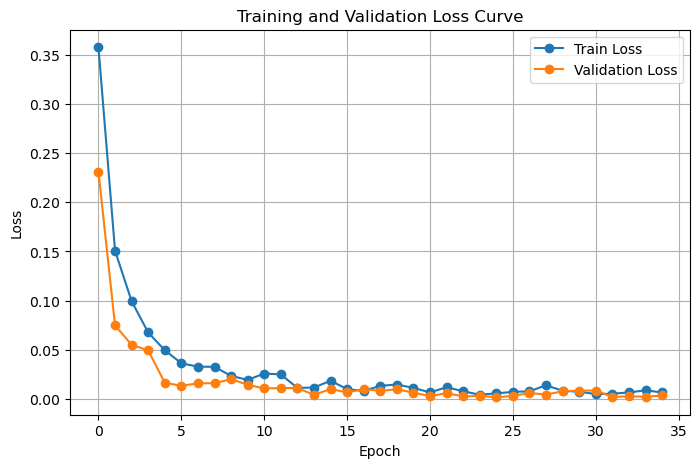

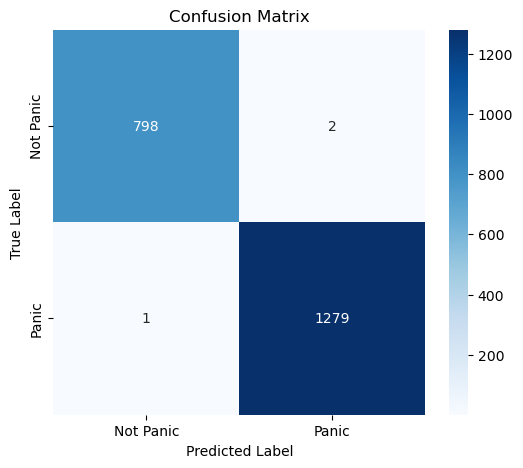

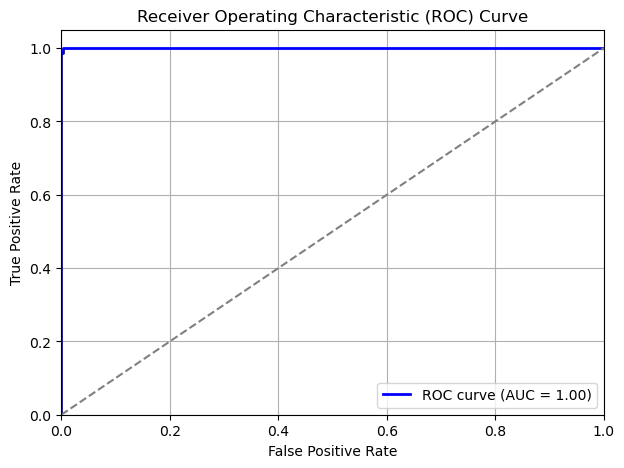

In [12]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
import pickle 

# Visualization functions
def plot_loss_curve(train_loss, val_loss):
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss, label='Train Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plt.grid()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Not Panic", "Panic"], 
                yticklabels=["Not Panic", "Panic"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

def main():
    # Device configuration: use GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load dataset
    dataset_path = 'tess_audio_dataset/TESS Toronto emotional speech set data/'
    X_raw, y = load_tess_dataset(dataset_path)
    
    # Check if any audio files were loaded
    if len(X_raw) == 0:
        raise ValueError("No audio files were loaded. Please check the dataset path and file formats.")
    
    # Feature extraction
    print("Extracting features...")
    features_list = [extract_features(audio) for audio in X_raw]
    if len(features_list) == 0:
        raise ValueError("No features were extracted. Check your audio files and feature extraction function.")
    X = np.array(features_list)
    
    # Data augmentation for panic class (label == 1)
    panic_indices = np.where(np.array(y) == 1)[0]
    for idx in panic_indices:
        augmented_audios = augment_audio(X_raw[idx])
        for audio in augmented_audios:
            features = extract_features(audio)
            X = np.vstack([X, features])
            y = np.append(y, 1)
    
    # Check the shape of X (must be 2D)
    if X.ndim != 2:
        raise ValueError(f"Extracted features should be a 2D array but got shape {X.shape}")
    
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Save the scaler to a file for later inference
    scaler_path = 'scaler.pkl'
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"Scaler saved to {scaler_path}")
    
    # Train-test split (80-20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    # Further split training set into train and validation sets (80-20 split of training data)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
    )
    
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor   = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
    X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor  = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    
    # Create DataLoaders
    batch_size = 32
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Build model
    input_dim = X_train.shape[1]
    model = CalmaAlertModel(input_dim).to(device)
    
    # Calculate class weight (for positive class) for imbalance:
    num_neg = np.sum(np.array(y) == 0)
    num_pos = np.sum(np.array(y) == 1)
    pos_weight_value = num_neg / num_pos if num_pos > 0 else 1.0
    pos_weight = torch.tensor(pos_weight_value, dtype=torch.float32).to(device)
    
    # Use BCEWithLogitsLoss (which expects raw logits) with pos_weight for class imbalance
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop with early stopping and checkpointing
    epochs = 100
    patience = 10
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_path = 'calmalert_model.pt'
    
    # Lists to record losses for visualization
    train_loss_history = []
    val_loss_history = []
    
    for epoch in range(1, epochs + 1):
        model.train()
        train_losses = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
        
        # Evaluate on validation set
        model.eval()
        val_losses = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_losses.append(loss.item())
        
        avg_train_loss = np.mean(train_losses)
        avg_val_loss = np.mean(val_losses)
        train_loss_history.append(avg_train_loss)
        val_loss_history.append(avg_val_loss)
        print(f"Epoch {epoch}: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # Save the best model
            torch.save(model.state_dict(), best_model_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break
    
    # Load best model for evaluation
    model.load_state_dict(torch.load(best_model_path))
    
    # Evaluation on test set
    model.eval()
    test_losses = []
    all_preds = []    # binary predictions
    all_probs = []    # probabilities (after sigmoid)
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_losses.append(loss.item())
            
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).float()
            all_preds.extend(preds.cpu().numpy().flatten())
            all_probs.extend(probs.cpu().numpy().flatten())
            all_targets.extend(targets.cpu().numpy().flatten())
    
    avg_test_loss = np.mean(test_losses)
    print(f"\nTest Loss: {avg_test_loss:.4f}")
    
    # Compute evaluation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_targets))
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    
    # Visualizations
    plot_loss_curve(train_loss_history, val_loss_history)
    plot_confusion_matrix(all_targets, all_preds)
    plot_roc_curve(all_targets, all_probs)

if __name__ == "__main__":
    main()

# Custom Audio


In [57]:
def predict_custom_audio(file_path, model, scaler, device, threshold=0.6):
    """
    Loads a custom audio file, extracts features, scales them, and predicts the output.
    The decision threshold is adjustable.
    """
    # Load the audio file
    audio, sr = load_audio_file(file_path)
    
    # Visualize the waveform
    plt.figure(figsize=(10, 3))
    plt.plot(audio)
    plt.title("Audio Waveform")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()
    
    # Extract features
    features = extract_features(audio, sr)
    print("Extracted features:", features)
    
    # Ensure the features are in 2D shape: (1, n_features)
    features = np.array(features).reshape(1, -1)
    
    # Apply scaling using the provided scaler
    features_scaled = scaler.transform(features)
    
    # Convert features to a torch tensor and move to the correct device
    features_tensor = torch.tensor(features_scaled, dtype=torch.float32).to(device)
    
    # Set model to evaluation mode and predict
    model.eval()
    with torch.no_grad():
        output = model(features_tensor)
        prob = torch.sigmoid(output).item()
        prediction = 1 if prob >= threshold else 0
    
    print(f"Predicted Probability: {prob:.4f}")
    print("Prediction:", "Panic" if prediction == 1 else "Not Panic")
    return prediction, prob

In [59]:
def load_audio_file(file_path, sr=22050):
    """
    Load an audio file using librosa.
    """
    audio, sr = librosa.load(file_path, sr=sr)
    return audio, sr

Model loaded successfully.
Scaler loaded successfully.


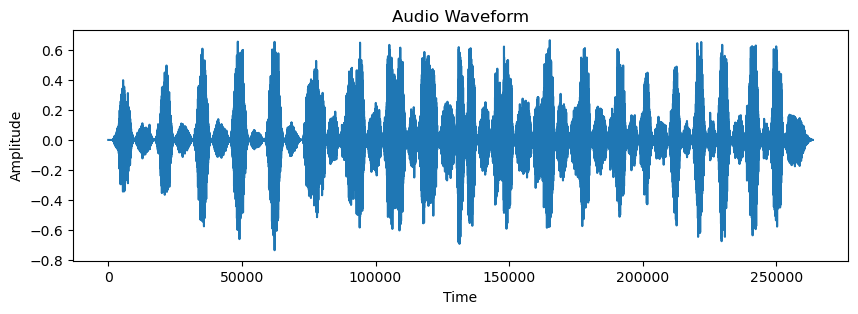

Extracted features: [ 8.16135688e-02  2.25468371e-01 -1.76164673e+02  6.24383464e+01
 -9.97420040e+01  9.73123263e+00 -5.86285035e+01  2.67308245e+01
 -4.51159597e+01  4.75106720e+00 -2.69189435e+01  2.17007296e+01
  1.71298140e+01 -8.87502378e+00  1.63873278e+01  1.43133943e+01
  1.22076314e+01  1.44868596e+01  1.72245616e+01  1.80028024e+01
  1.99989883e+01  7.46565183e+01  4.09655619e-01  3.69388327e-01
  3.76846639e-01  5.25383147e-01  6.85600428e-01  8.20714586e-01
  8.46125599e-01  6.94907200e-01  7.06266261e-01  7.26707897e-01
  5.84099258e-01  4.06800147e-01  6.02280226e-02  4.43847187e-02
  9.30680400e+01  2.98772826e+01  1.96435436e+01  1.39324296e+01
  1.52931573e+01  9.76463652e+00  1.23413106e+01  1.02881308e+01
  9.78151793e+00  9.70725391e+00  7.61945335e+00  9.13061075e+00
  7.48363032e+00  4.77772830e+00  3.11329546e+00  3.89570767e+00
  2.82640720e+00  2.63018721e+00  2.78786924e+00  3.84530251e+00
  1.63455487e-01  1.48967663e-01  1.40035739e-01  1.86159206e-01
  2.0

(0, 1.0)

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define input dimension
input_dim = 20

# Load the trained model
model = CalmaAlertModel(input_dim).to(device)
model_path = 'calmalert_model.pt'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file {model_path} not found!")
model.load_state_dict(torch.load(model_path, map_location=device))
print("Model loaded successfully.")

# Load the scaler from pickle file
scaler_path = 'scaler.pkl'
if not os.path.exists(scaler_path):
    raise FileNotFoundError(f"Scaler file {scaler_path} not found! Make sure you saved it during training.")
with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)
print("Scaler loaded successfully.")

# Path to your custom audio file (update this to your file location)
custom_audio_file = "panic_1.wav"
if not os.path.exists(custom_audio_file):
    raise FileNotFoundError(f"Audio file {custom_audio_file} not found!")

# Make a prediction on the custom audio file
predict_custom_audio(custom_audio_file, model, scaler, device, threshold=10)

In [ ]:
dataset_path = 'tess_audio_dataset/TESS Toronto emotional speech set data/'
X_raw, y = load_tess_dataset(dataset_path)
    
    # Check if any audio files were loaded
if len(X_raw) == 0:
    raise ValueError("No audio files were loaded. Please check the dataset path and file formats.")
    
    # Feature extraction
print("Extracting features...")
features_list = [extract_features(audio) for audio in X_raw]
if len(features_list) == 0:
     raise ValueError("No features were extracted. Check your audio files and feature extraction function.")
X = np.array(features_list)
    
    # Data augmentation for panic class (label == 1)
panic_indices = np.where(np.array(y) == 1)[0]
for idx in panic_indices:
    augmented_audios = augment_audio(X_raw[idx])
    for audio in augmented_audios:
         features = extract_features(audio)
         X = np.vstack([X, features])
         y = np.append(y, 1)
    
    # Check the shape of X (must be 2D)
if X.ndim != 2:
    raise ValueError(f"Extracted features should be a 2D array but got shape {X.shape}")
    
    # Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

Found 5600 audio files.
Extracting features...


In [ ]:
 # Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, stratify=y, random_state=42
)
    
    # Further split training set into train and validation sets (80-20 split of training data)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Train a simple Random Forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")